In [1]:
import os
import re
import collections
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from random import sample

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('datasets/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]
handled_text = names

In [3]:
#all unique characters go here
tokens = list(set(''.join(handled_text)))

num_tokens = len(tokens)
print ('num_tokens =', num_tokens)

num_tokens = 53


In [4]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [6]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [7]:
print(handled_text[3])
print(to_matrix(handled_text[3:5], token_to_id)[0])
print(len(handled_text[3]))

 Abaidulin
[ 3 37  5 19 40  6 44 47 40 28  3]
10


In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
from IPython.display import clear_output
from random import sample

class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=32, hidden_size=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.LSTM = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, h=None, c=None):
        if h is not None and c is not None:
            out_put, (h_new, c_new) = self.LSTM(self.emb(x), (h, c))
        else:
            out_put, (h_new, c_new) = self.LSTM(self.emb(x))
            
        next_logits = self.hid_to_logits(out_put)
        next_logp = F.log_softmax(next_logits, dim=-1)
        
        return next_logp, h_new, c_new

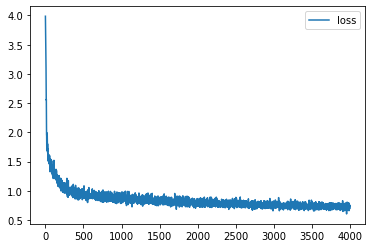

In [10]:
MAX_LENGTH = max(map(len, handled_text))

model = CharLSTMLoop()
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
history = []

best_loss = 6

best_model_wts = copy.deepcopy(model.state_dict())

for i in range(4000):
    batch_ix = to_matrix(sample(handled_text, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)

    logp_seq, _, _ = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

    if loss < best_loss:
        best_loss = loss
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.cpu().data.numpy())
    if (i + 1) % 20 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [11]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [12]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    
    h_t = None
    c_t = None
    if len(seed_phrase) > 1:
        _, h_t, c_t = model.forward(x_sequence[:, :-1], h_t)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, h_t, c_t = model.forward(x_sequence[:, -1].unsqueeze(-1), h_t, c_t)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence[0].data.numpy()])


model = model.to('cpu')
for _ in range(100):
    print(generate_sample(model, seed_phrase=' ', temperature=0.5))

 Martyushkin         
 Halushkin           
 Baidanov            
 Baidanoff           
 Zimatov             
 Vakachev            
 Zhituhin            
 Velikov             
 Abdulazyan          
 Makhorev            
 Jablonov            
 Atamahov            
 Dubin               
 Mashkov             
 Bakalov             
 Tovashenko          
 Rozhankin           
 Andrusichev         
 Lapinsky            
 Valennikov          
 Mokhin              
 Voloseev            
 Beloishtein         
 Zhitin              
 Belovarov           
 Babuhov             
 Zherkov             
 Guzin               
 Zinov               
 Martyshev           
 Glushin             
 Tsaramovsky         
 Batsevich           
 Shainer             
 Abdulladzhanoff     
 Babakov             
 Babashov            
 Awaloff             
 Litin               
 Babakhin            
 Abitov              
 Turkovich           
 Grashin             
 Anorin              
 Bakhtin             
 Maksyukin

In [19]:
torch.save(model, 'Names_generation.pt')